# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.963858,False,-3.074556
1,-0.655678,False,-1.833500
2,1.040697,False,2.101251
3,-4.055931,False,-10.338288
4,-1.228112,False,-2.094105
...,...,...,...
995,-0.332668,True,4.455656
996,-2.141019,False,-5.439277
997,-0.319915,False,-1.385808
998,-0.036504,False,0.351955


<AxesSubplot:xlabel='v0'>

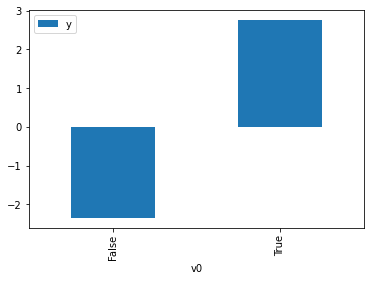

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

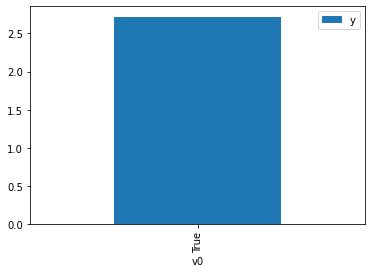

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.425604,False,-4.256299,0.857225,1.166554
1,-1.561302,False,-3.065562,0.876265,1.141208
2,0.950987,False,2.095443,0.249943,4.000912
3,-0.145665,False,-0.298377,0.558547,1.790361
4,-1.051685,False,-2.957263,0.792083,1.262494
...,...,...,...,...,...
995,-0.061373,False,1.108853,0.533131,1.875713
996,-3.171785,False,-10.776395,0.980484,1.019904
997,-0.201144,False,-0.971216,0.575117,1.738776
998,-1.630449,False,-4.063032,0.885101,1.129815


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.948477,True,1.959687,0.229354,4.360073
1,-1.449386,True,1.458671,0.139270,7.180304
2,-1.145923,True,1.790601,0.189667,5.272395
3,-1.119400,True,1.997633,0.194676,5.136740
4,-1.081335,True,3.055659,0.202039,4.949533
...,...,...,...,...,...
995,-1.853064,True,-0.320868,0.090095,11.099434
996,-1.663637,True,0.209020,0.110856,9.020681
997,-1.399626,True,0.073670,0.146686,6.817262
998,-0.810837,True,1.188035,0.260280,3.842009


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9909.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:09:34   Log-Likelihood:                         -1415.7
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7465      0.023    119.477      0.000       2.701       2.792
x2             4.9704      0.059     84.100      0.000       4.854       5.086
==============================================================================
Omnibus:                        0.211   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.290
Skew:                          -0.018   Prob(JB):                        0.865
Kurtosis:                       2.924   Cond. No.                         2.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""